In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

Basado en la notebook de: https://www.kaggle.com/code/sdeogade/bitcoin-price-prediction-using-lstm

In [2]:
# configuracion
data_dir = '../data'

In [3]:
# Cargamos el dataset de Bitcoin desde un archivo CSV (asumiendo que ya lo has descargado de Kaggle)
data = pd.read_csv(data_dir+'/'+'btcusd_1-min_data.csv')  # Adjust filename as per your Kaggle download
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data.set_index('Timestamp', inplace=True)

In [4]:
data.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [5]:
# Verifico si hay valores nulos
print("Valores nulos en el dataset:")
print(data.isnull().sum())

Valores nulos en el dataset:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [6]:
daily_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].resample('D').agg({
    'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'
}).dropna() # Resampleo los datos a diario y eliminar filas con NaN

In [7]:
daily_data.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742


In [8]:
# Información general del dataset
print("Información del dataset:")
print(daily_data.info())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4897 entries, 2012-01-01 to 2025-05-28
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4897 non-null   float64
 1   High    4897 non-null   float64
 2   Low     4897 non-null   float64
 3   Close   4897 non-null   float64
 4   Volume  4897 non-null   float64
dtypes: float64(5)
memory usage: 229.5 KB
None


In [9]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(daily_data.describe())


Estadísticas descriptivas:
                Open           High            Low          Close  \
count    4897.000000    4897.000000    4897.000000    4897.000000   
mean    17875.853290   18298.053800   17438.409949   17898.019802   
std     24824.840554   25350.942011   24279.485865   24857.561197   
min         4.380000       4.380000       3.800000       4.380000   
25%       427.000000     434.890000     418.000000     426.880000   
50%      6674.960000    6826.280000    6510.000000    6685.750000   
75%     27809.000000   28268.000000   27197.000000   27847.000000   
max    111742.000000  112000.000000  109252.000000  111743.000000   

              Volume  
count    4897.000000  
mean     7597.176432  
std      9094.833405  
min         0.000000  
25%      2089.564117  
50%      4731.654249  
75%      9857.352049  
max    127286.486533  


## Analisis Exploratorio de Datos

## Gráfico de series temporales del precio de cierre de Bitcoin
Este gráfico ilustra la tendencia a largo plazo del precio de Bitcoin.

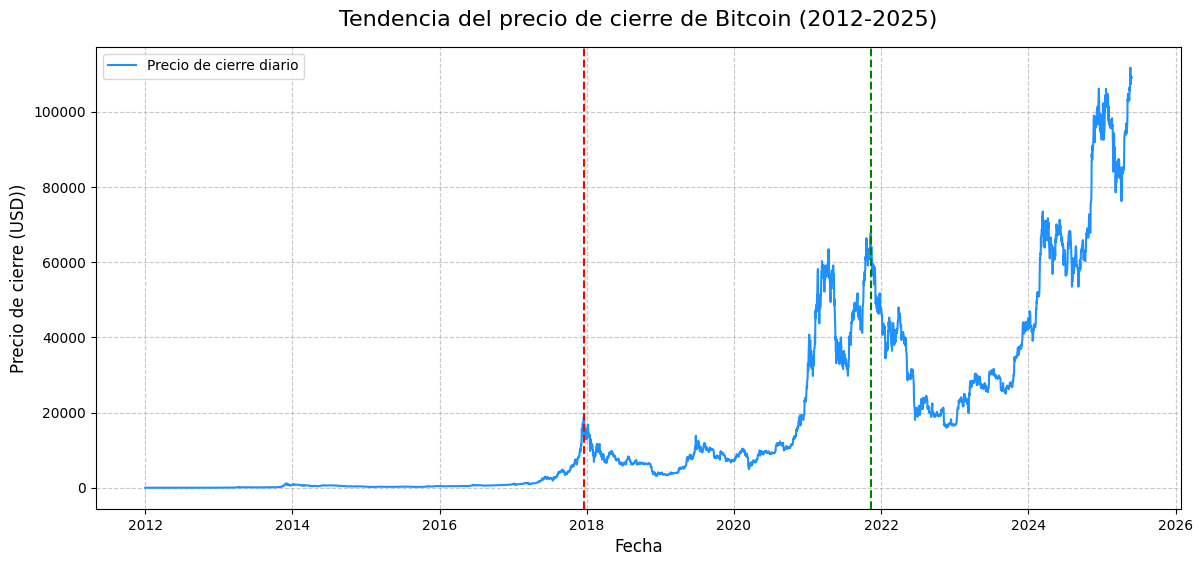

In [10]:
# Gráfico de series de tiempo del precio de cierre de Bitcoin
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Close'], label='Precio de cierre diario', color='#1E90FF')
plt.title('Tendencia del precio de cierre de Bitcoin (2012-2025)', fontsize=16, pad=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de cierre (USD))', fontsize=12)
plt.axvline(pd.Timestamp('2017-12-17'), color='red', linestyle='--')
plt.axvline(pd.Timestamp('2021-11-10'), color='green', linestyle='--')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Media móvil y volatilidad
Este gráfico destaca las tendencias y la volatilidad utilizando una media móvil de 30 días y una desviación estándar.

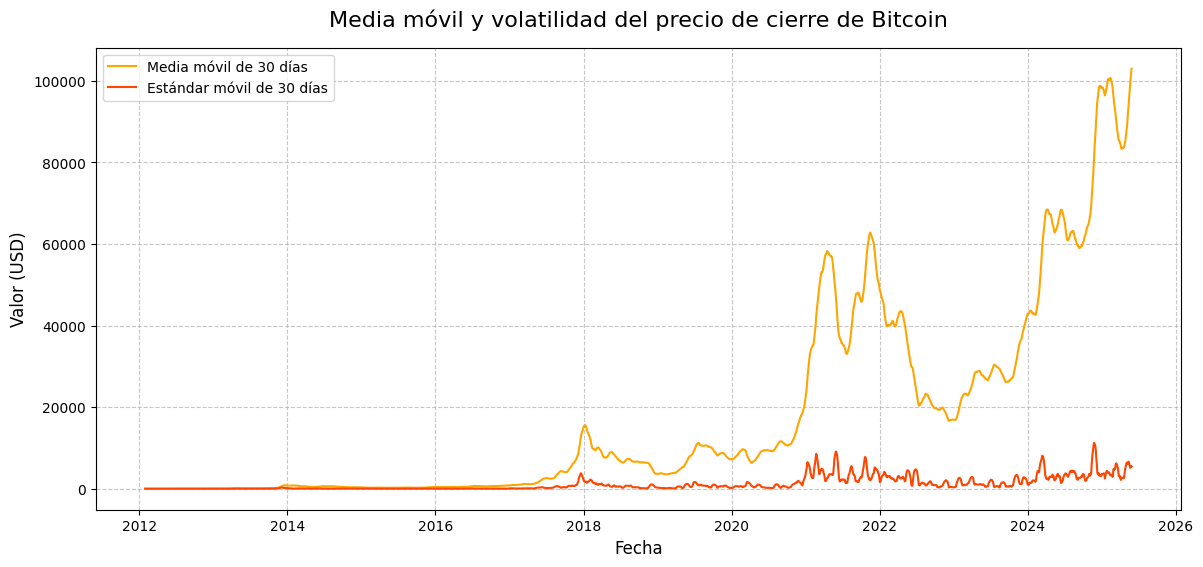

In [11]:
# Media móvil y volatilidad
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Close'].rolling(window=30).mean(), label='Media móvil de 30 días', color='#FFA500')
plt.plot(daily_data.index, daily_data['Close'].rolling(window=30).std(), label='Estándar móvil de 30 días', color='#FF4500')
plt.title('Media móvil y volatilidad del precio de cierre de Bitcoin', fontsize=16, pad=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Distribución de los rendimientos diarios
Este histograma analiza la distribución de los cambios porcentuales diarios.

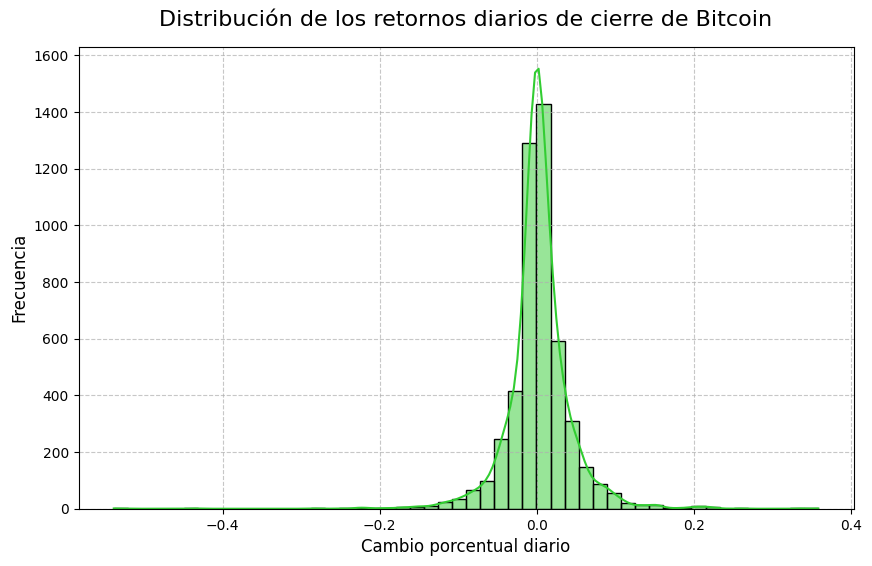

In [12]:
# Distribución de los rendimientos diarios
daily_returns = daily_data['Close'].pct_change().dropna()
plt.figure(figsize=(10, 6))
sns.histplot(daily_returns, bins=50, kde=True, color='#32CD32')
plt.title('Distribución de los retornos diarios de cierre de Bitcoin', fontsize=16, pad=15)
plt.xlabel('Cambio porcentual diario', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Gráfico de Velas Interactivo
Un gráfico de velas interactivo, ampliamente utilizado por los usuarios del mercado de valores, muestra los movimientos de precios y el volumen.
*Las velas verdes/rojas indican subidas/bajadas de precios, mientras que las barras de volumen resaltan la actividad de trading. Acerque y pase el cursor para un análisis detallado.*

In [13]:
# Gráfico de velas interactivo
fig = go.Figure(data=[go.Candlestick(x=daily_data.index,
                                     open=daily_data['Open'],
                                     high=daily_data['High'],
                                     low=daily_data['Low'],
                                     close=daily_data['Close'],
                                     name='Candlestick')])

fig.add_trace(go.Bar(x=daily_data.index, y=daily_data['Volume'], name='Volume', yaxis='y2'))

fig.update_layout(
    title='Gráfico interactivo de velas de Bitcoin con volumen (2012-2025)',
    yaxis_title='Precio (USD)',
    yaxis2=dict(title='Volumen', overlaying='y', side='right'),
    xaxis_title='Fecha',
    template='plotly_dark',
    height=600
)

fig.show()

## Gráfico de Volumen

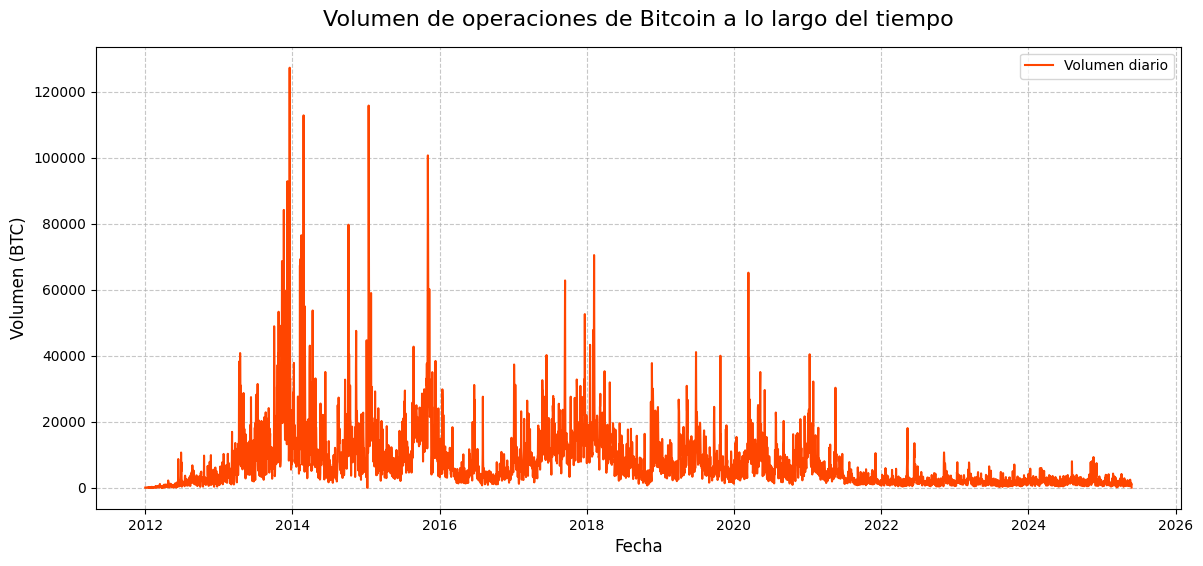

In [14]:
# Volume Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Volume'], label='Volumen diario', color='#FF4500')
plt.title('Volumen de operaciones de Bitcoin a lo largo del tiempo', fontsize=16, pad=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Volumen (BTC)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Gráfico del índice de fuerza relativa (RSI)
El RSI mide el impulso en una escala de 0 a 100 para identificar condiciones de sobrecompra (>70) o sobreventa (<30).

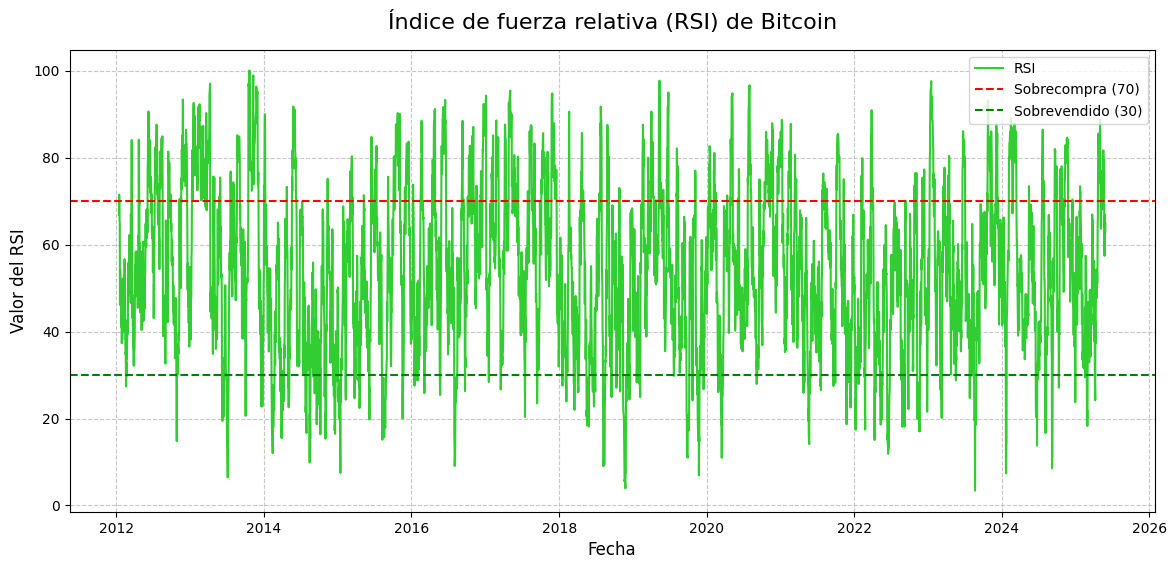

In [15]:
# Gráfico del índice de fuerza relativa (RSI)
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))

rsi = calculate_rsi(daily_data['Close'])
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index[-len(rsi):], rsi, label='RSI', color='#32CD32')
plt.axhline(70, color='red', linestyle='--', label='Sobrecompra (70)')
plt.axhline(30, color='green', linestyle='--', label='Sobrevendido (30)')
plt.title('Índice de fuerza relativa (RSI) de Bitcoin', fontsize=16, pad=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor del RSI', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Gráfico de convergencia-divergencia de medias móviles (MACD)
El MACD rastrea la relación entre dos medias móviles para identificar cambios de tendencia.

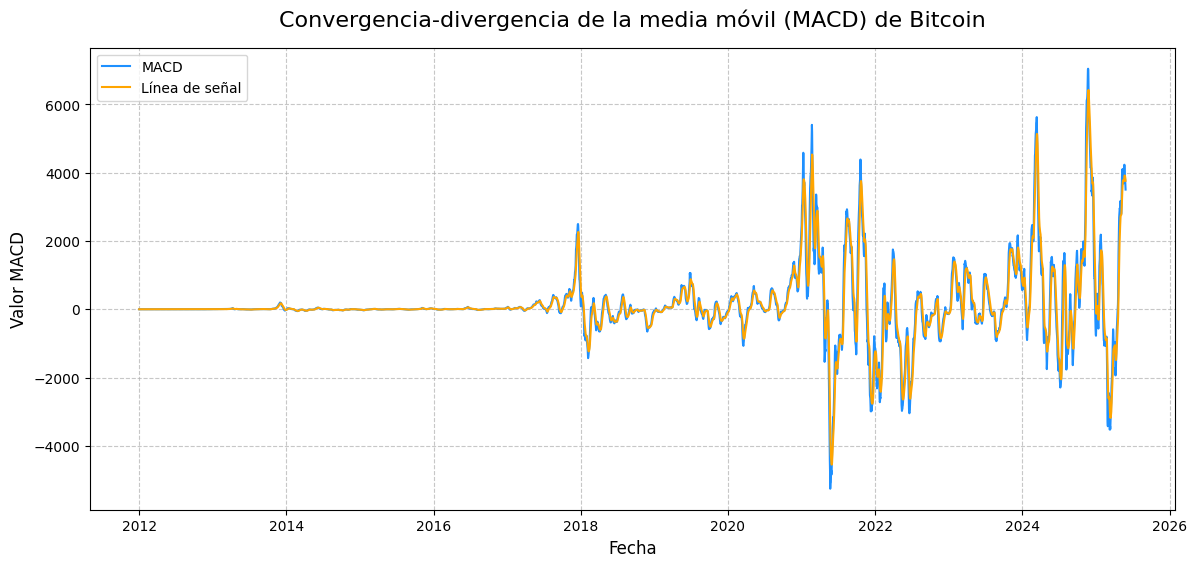

In [16]:
# Gráfico de convergencia y divergencia de medias móviles (MACD)
def calculate_macd(data, slow=26, fast=12, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

macd, signal_line = calculate_macd(daily_data['Close'])
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index[-len(macd):], macd, label='MACD', color='#1E90FF')
plt.plot(daily_data.index[-len(signal_line):], signal_line, label='Línea de señal', color='#FFA500')
plt.title('Convergencia-divergencia de la media móvil (MACD) de Bitcoin', fontsize=16, pad=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor MACD', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
